In [1]:
# ===================================================================
#                          METADATA
# ===================================================================

# -------------------- General Information --------------------------
# 1. Title: Automated Fitting Script
# 2. Description: Supporting script for the article "Ionic Liquid--Electrode 
#    Interface: from One Law To Fit Them All to One Model To Predict Them All".
#    This script automatically reads .csv data files from its folder and 
#    conducts either capacitance-potential C(U) or surface charge 
#    density-potential S(U) fitting.
# 3. Authors:
#    - Ba Long Nguyen (ORCID: 0009-0003-7682-9851)
#    - Vladislav Ivanistsev (ORCID: 0000-0003-4517-0540)
# 4. Contact: balongn99@gmail.com & vladislav.ivanistsev@gmail.com
# 5. Keywords: differential capacitance, ionic liquids, modelling, fitting.

# -------------------- Identifiers & Versioning ---------------------
# 6. Version: 1.0.0
# 7. Date: 
#    - Created: 2025-06-13
#    - Last Modified: 2025-09-24
# 8. DOI: https://doi.org/10.1016/j.elecom.2025.108049

# -------------------- Usage & Accessibility ------------------------
# 10. License: This work is licensed under the MIT License.
# 11. Dependencies:
#     - Python 3.8+
#     - See 'requirements.txt' for necessary libraries (e.g., numpy, pandas, scipy, matplotlib).
# 12. Usage Notes:
#     - Place this script in the same folder as the target .csv data files.
#     - The script automatically discovers and processes all .csv files.
#     - For fitting, sM (surface charge density at PMC) must be provided in the data file.
#     - uM (PMC) can be provided or left empty to be fitted.
#     - Fitting can be done with or without potential and capacitance uncertainties.
# 13. Data Format:
#     - Input: .csv file with metadata in the first two rows, followed by data.
#     - Default Data Column Order (if headers are absent): U, dU, S, C, dC
#     - Units: Potential (V), Capacitance (μF/cm²), Surface Charge Density (μC/cm²)

Detected header columns: ['C', 'U']
exampledatastructure.csv, branch pos: Using RMSE fit (no uncertainties).
exampledatastructure.csv, branch neg: Using RMSE fit (no uncertainties).
exampledatastructure [pos]: a_M=0.689, k=12.250
exampledatastructure [neg]: a_M=0.656, k=26.496


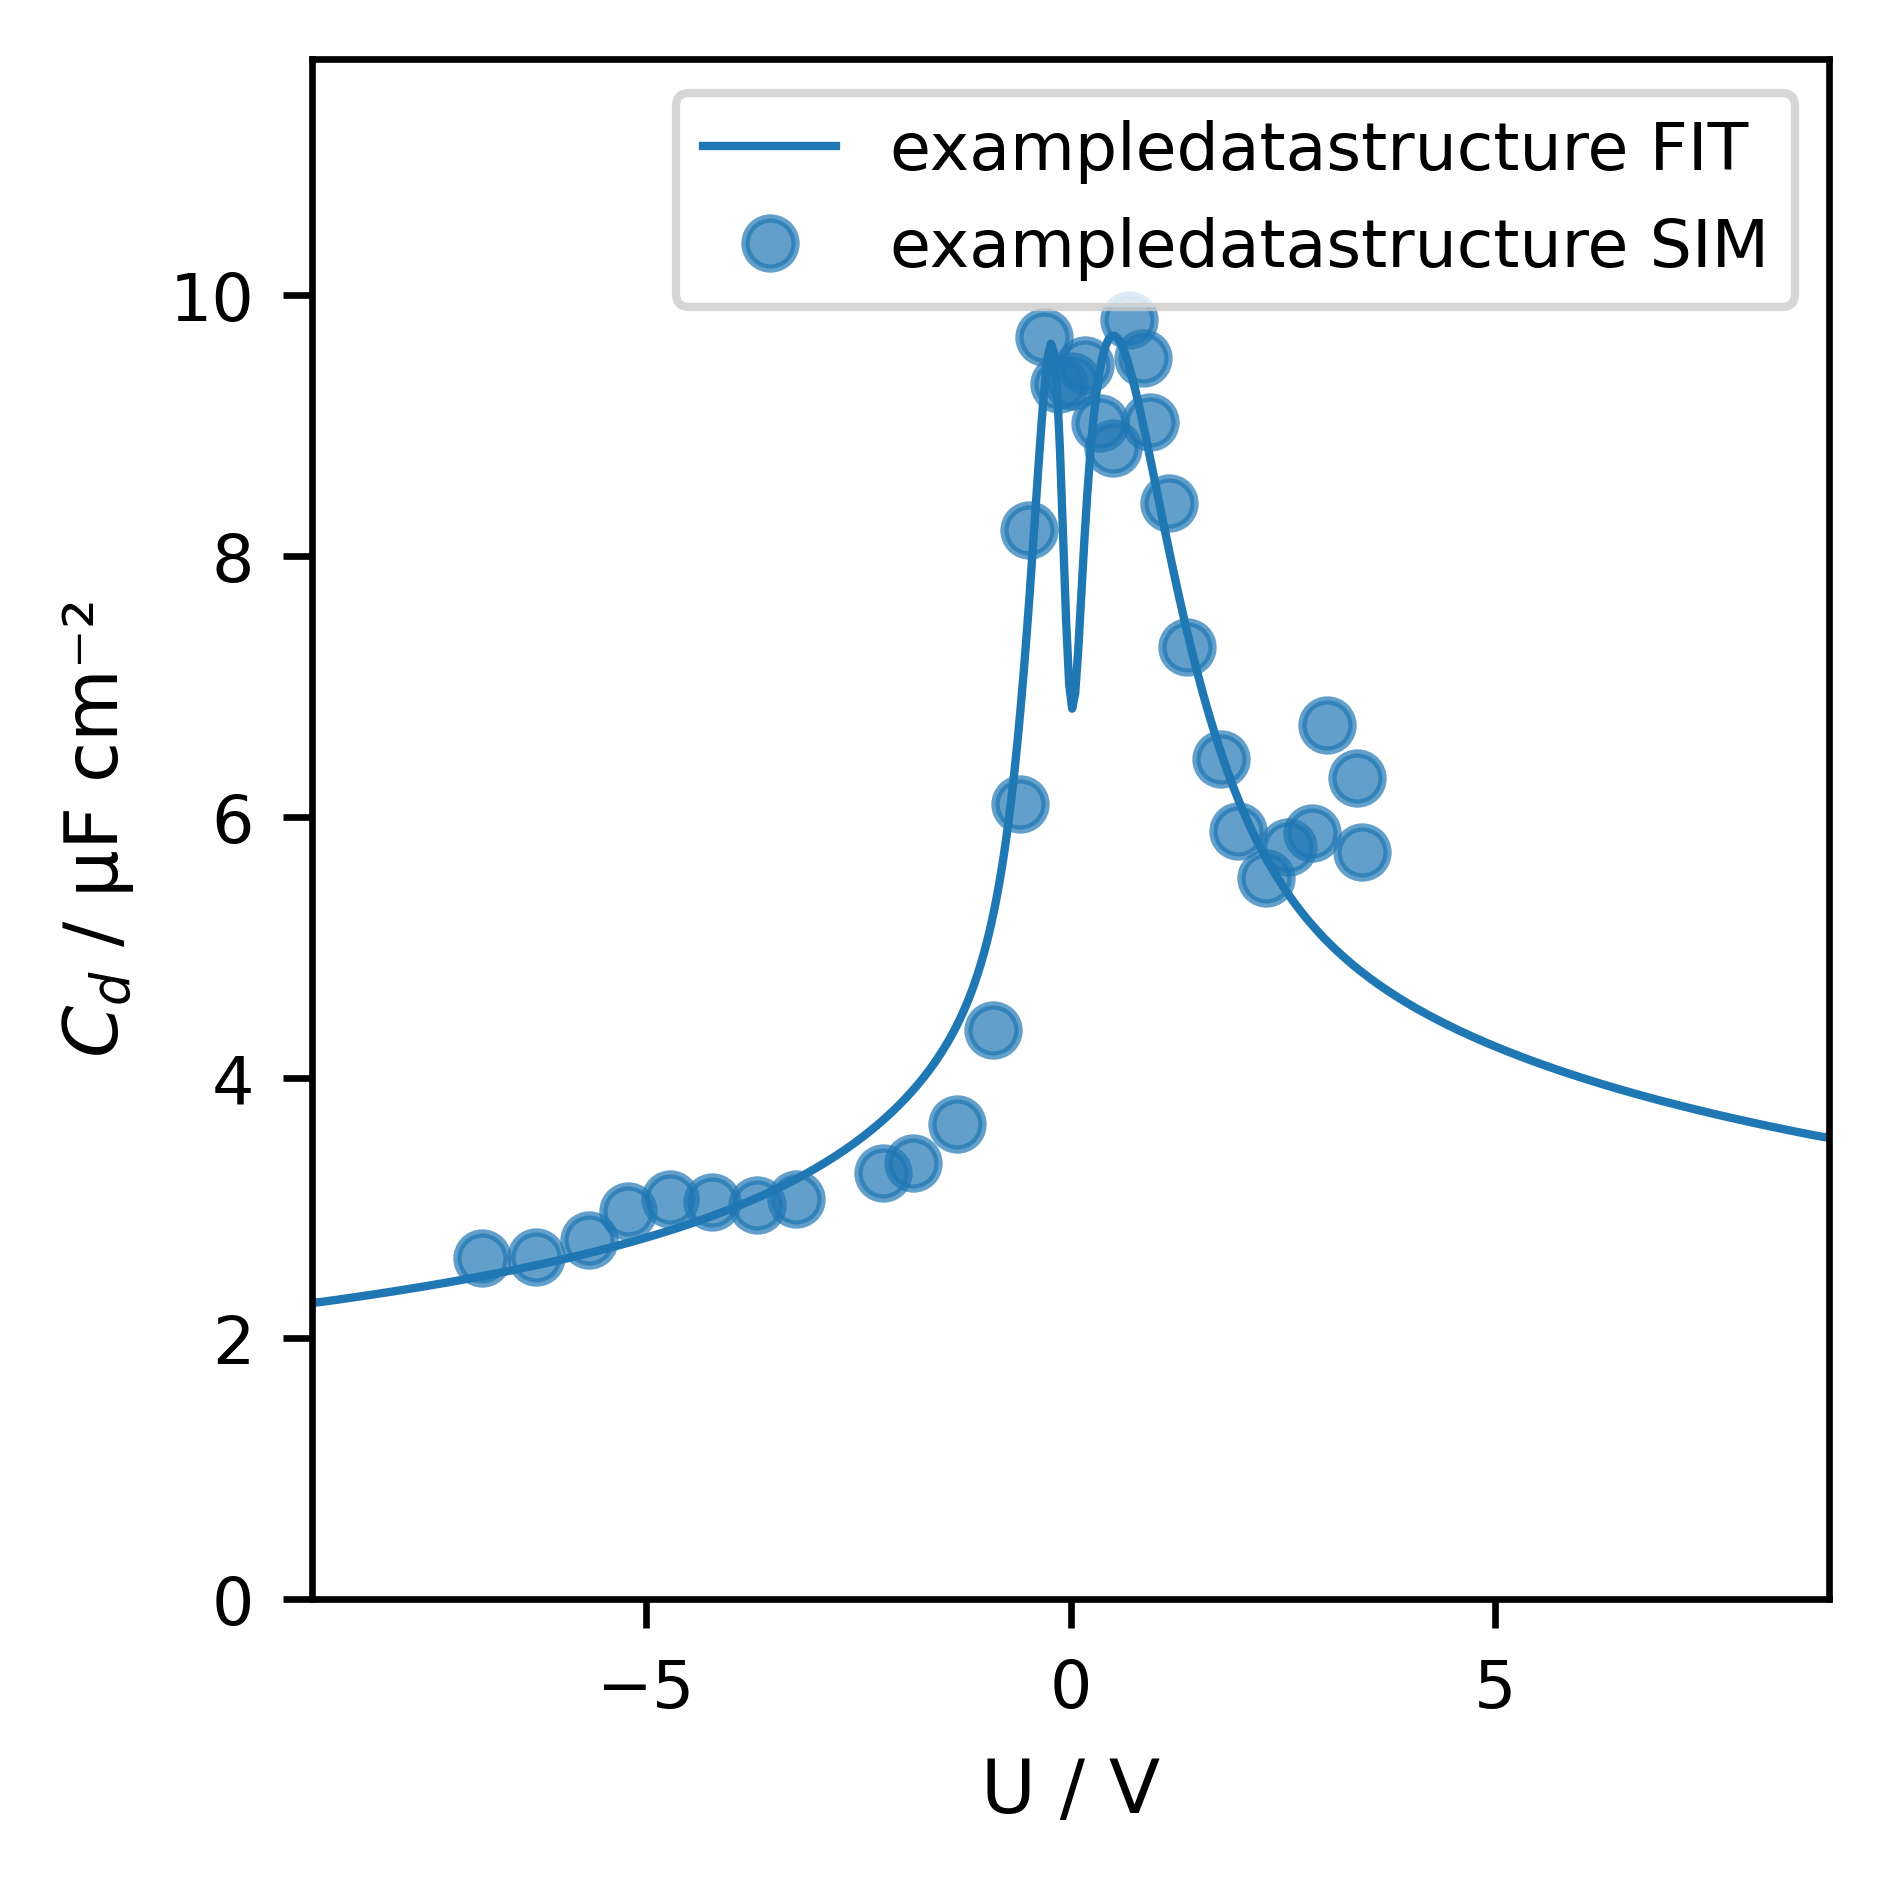

In [2]:
import glob
import os
import csv
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import differential_evolution, least_squares
import matplotlib.pyplot as plt

# Matplotlib styling
i = 8.25 / 2.54  # inches
plt.rc('figure', figsize=(i, i), dpi=600, titlesize=10)
plt.rc('lines', linewidth=1)
plt.rc('font', size=10, family='sans-serif')
plt.rc('axes', titlesize=10, labelsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)

csv_files = sorted(glob.glob('*.csv'))
if not csv_files:
    raise RuntimeError("No CSV files found in current folder.")

def C_model(u, uM, aM, k, sM):
    a = aM + (1 - aM) * np.exp(-k * u / uM)
    a_p = (1 - aM) * (-k / uM) * np.exp(-k * u / uM)
    return sM * (u / uM) ** a * (a_p * np.log(u / uM) + a / u)

def read_fixed_columns_csv(path, skiprows, ncols=5, colnames=['U','DU','S','C','DC']):
    rows = []
    with open(path) as f:
        lines = f.read().splitlines()[skiprows:]
    for line in lines:
        if not line.strip():
            continue
        toks = [t.strip() for t in line.split(',')]
        toks = (toks + [None]*ncols)[:ncols]
        rows.append(toks)
    df = pd.DataFrame(rows, columns=colnames)
    return df

def safe_float(val):
    try:
        # Handles None, empty strings, and np.nan gracefully
        if val is None or str(val).strip() == '':
            return np.nan
        return float(val)
    except (TypeError, ValueError):
        return np.nan

def process_file(path):
    # --- Read metadata ---
    with open(path, newline='') as f:
        reader = csv.reader(f)
        meta_keys = next(reader)
        meta_vals = next(reader)
    meta = dict(zip([k.strip() for k in meta_keys], [v.strip() for v in meta_vals]))

    uM_pos = safe_float(meta.get('uM_pos', meta.get('uM pos', np.nan)))
    if np.isnan(uM_pos):
        uM_pos = safe_float(meta.get('uM pos', np.nan))
    uM_neg = safe_float(meta.get('uM_neg', meta.get('uM neg', np.nan)))
    if np.isnan(uM_neg):
        uM_neg = safe_float(meta.get('uM neg', np.nan))
    sM_pos = safe_float(meta.get('sM_pos', meta.get('sM pos', np.nan)))
    if np.isnan(sM_pos):
        sM_pos = safe_float(meta.get('sM pos', np.nan))
    sM_neg = safe_float(meta.get('sM_neg', meta.get('sM neg', np.nan)))
    if np.isnan(sM_neg):
        sM_neg = safe_float(meta.get('sM neg', np.nan))

    # --- Find where the actual data table begins ---
    with open(path) as f:
        lines = f.read().splitlines()
    skiprows = 2
    while skiprows < len(lines) and not any(tok.strip() for tok in lines[skiprows].split(',')):
        skiprows += 1
    if skiprows >= len(lines):
        raise RuntimeError(f"{path}: No data found after metadata.")

    # Robust header detection
    header_tokens = [x.strip().upper() for x in lines[skiprows].split(',')]
    allowed_headers = set(['U', 'DU', 'S', 'C', 'DC'])
    is_header = (
        ('U' in header_tokens) and
        (('C' in header_tokens) or ('S' in header_tokens))
    )

    if is_header:
        df = pd.read_csv(path, skiprows=skiprows, header=0)
        df.columns = [c.strip().upper() for c in df.columns]
        print(f"Detected header columns: {df.columns.tolist()}")
    else:
        df = read_fixed_columns_csv(path, skiprows, ncols=5, colnames=['U','dU','S','C','dC'])
        print(f"No header: assigned columns: {df.columns.tolist()}")
        print(df.head())

    # --- Numeric extraction, robust to missing columns ---
    U_all  = pd.to_numeric(df['U'], errors='coerce').to_numpy() if 'U' in df.columns else np.full(len(df), np.nan)
    C_all  = pd.to_numeric(df['C'], errors='coerce').to_numpy() if 'C' in df.columns else None
    dC_all = pd.to_numeric(df['DC'], errors='coerce').to_numpy() if 'DC' in df.columns else None
    S_all  = pd.to_numeric(df['S'], errors='coerce').to_numpy() if 'S' in df.columns else None
    dU_all = pd.to_numeric(df['DU'], errors='coerce').to_numpy() if 'DU' in df.columns else None

    has_C = C_all is not None and np.isfinite(C_all).any()
    has_S = S_all is not None and np.isfinite(S_all).any()

    if has_C:
        pass
    elif has_S:
        idx0 = np.where(np.isclose(S_all, 0))[0]
        if idx0.size:
            U_all = U_all - U_all[idx0[0]]
        C_raw = np.gradient(S_all, U_all)
        if dU_all is not None and np.isfinite(dU_all).any():
            du = np.gradient(U_all)
            dU_trim = dU_all[1:-1]
            dC_all = np.abs(C_raw[1:-1]) * dU_trim / du[1:-1]
        else:
            dC_all = None
        C_smooth = gaussian_filter1d(C_raw, sigma=1)
        U_all = U_all[1:-1]
        C_all = C_smooth[1:-1]
    else:
        print("Columns found:", df.columns.tolist())
        print("First few lines:\n", df.head())
        return None

    mask = np.isfinite(U_all) & np.isfinite(C_all)
    if (dC_all is not None) and np.isfinite(dC_all).any():
        mask &= np.isfinite(dC_all)
    U = U_all[mask]
    C = np.abs(C_all[mask])
    dC = dC_all[mask] if dC_all is not None else None

    # --- Fit branches ---
    branches = []
    for branch, cond, uM0, sM0 in [
        ('pos', U > 0, uM_pos, sM_pos),
        ('neg', U < 0, uM_neg, sM_neg)
    ]:
        Ub = U[cond]
        if Ub.size < 3:
            continue
        Cb = C[cond]
        dCb = dC[cond] if dC is not None else None
        free_uM = not np.isfinite(uM0)
        # --- Use chi-squared if dC is available and valid; else OLS ---
        if dCb is not None and np.isfinite(dCb).sum() >= 3:
            w = np.where(np.isfinite(dCb), 1 / dCb**2, 0)
            use_chisq = True
            print(f"{path}, branch {branch}: Using chi-square fit (uncertainty-weighted).")
        else:
            w = np.ones_like(Cb)
            use_chisq = False
            print(f"{path}, branch {branch}: Using RMSE fit (no uncertainties).")
        def resid(p):
            uM_fit, aM, k = (p if free_uM else (uM0, p[0], p[1]))
            if np.sign(uM_fit) != np.sign(sM0) or abs(uM_fit) < 1e-8:
                return np.full_like(Ub, 1e6)
            return (C_model(Ub, uM_fit, aM, k, sM0) - Cb) * np.sqrt(w)
        umin, umax = (0.1 * Ub.min(), 10 * Ub.max()) if branch == 'pos' else (10 * Ub.min(), 0.1 * Ub.max())
        if free_uM:
            bounds = [(umin, umax), (0, 1), (0, 100)]
            x0 = [(umin + umax) / 2, 0.5, 10]
        else:
            bounds = [(0, 1), (0, 100)]
            x0 = [0.5, 10]
        de_res = differential_evolution(lambda p: np.sum(resid(p) ** 2), bounds)
        ls_res = least_squares(resid, x0=de_res.x, bounds=np.transpose(bounds), method='trf')
        p_opt, J = ls_res.x, ls_res.jac
        JTJ = J.T @ J
        try:
            cov = np.linalg.inv(JTJ)
        except np.linalg.LinAlgError:
            cov = np.linalg.pinv(JTJ)
        if use_chisq:
            chi2 = np.sum(resid(p_opt) ** 2)
            cov *= chi2 / (Ub.size - p_opt.size)
        uMf, aMf, kf = (p_opt if free_uM else (uM0, p_opt[0], p_opt[1]))
        branches.append({'U': Ub, 'C': Cb, 'dC': dCb,
                         'params': (uMf, aMf, kf, sM0), 'free_uM': free_uM})
    if not branches:
        return None
    return {'file': os.path.splitext(os.path.basename(path))[0], 'branches': branches}

# --------- MAIN LOGIC ---------

results = [r for r in (process_file(p) for p in csv_files) if r and r['branches']]
all_branches = [b for r in results for b in r['branches']]

Us = [b['U'] for b in all_branches if b['U'].size > 0]
Cs = [b['C'] for b in all_branches if b['C'].size > 0]
if not Us or not Cs:
    raise RuntimeError("No valid data to plot! Exiting.")

allU = np.concatenate(Us)
uab = np.max(np.abs(allU))
u_grid = np.linspace(-uab-2, uab+2, 500)
allC = np.concatenate(Cs)
Cmax = np.max(allC)

# Print the first branch parameters for each file
for r in results:
    name = r['file']
    for br in r['branches']:
        uMf, aMf, kf, _ = br['params']
        branch_label = 'pos' if np.all(br['U'] > 0) else 'neg'
        if br['free_uM']:
            print(f"{name} [{branch_label}]: u_M={uMf:.3f}, a_M={aMf:.3f}, k={kf:.3f}")
        else:
            print(f"{name} [{branch_label}]: a_M={aMf:.3f}, k={kf:.3f}")

fig, ax = plt.subplots()
for r in results:
    name = r['file']
    C_tot = np.full_like(u_grid, np.nan)
    pos = next((b for b in r['branches'] if np.any(b['U']>0)), None)
    if pos:
        uMf,aMf,kf,sMf = pos['params']
        mask = u_grid >= 0
        C_tot[mask] = C_model(u_grid[mask], uMf, aMf, kf, sMf)
    neg = next((b for b in r['branches'] if np.any(b['U']<0)), None)
    if neg:
        uMf,aMf,kf,sMf = neg['params']
        mask = u_grid < 0
        C_tot[mask] = C_model(u_grid[mask], uMf, aMf, kf, sMf)
    C_smooth = gaussian_filter1d(np.abs(C_tot), sigma=2)
    ln, = ax.plot(u_grid, C_smooth, '-', label=f"{name} FIT")
    col = ln.get_color()
    # Only plot data if available
    Us = [b['U'] for b in r['branches'] if b['U'].size > 0]
    Cs = [b['C'] for b in r['branches'] if b['C'].size > 0]
    dCs = [b['dC'] for b in r['branches'] if b['dC'] is not None and b['dC'].size > 0]
    if Us and Cs:
        U_dat = np.concatenate(Us)
        C_dat = np.concatenate(Cs)
        if dCs and len(dCs) == len(Us):
            dC_dat = np.concatenate(dCs)
            ax.errorbar(U_dat, C_dat, yerr=dC_dat, fmt='o', color=col,
                        alpha=0.7, capsize=2, capthick=1, label=f"{name} SIM")
        else:
            ax.plot(U_dat, C_dat, 'o', color=col, alpha=0.7, label=f"{name} SIM")

ax.set_xlim([-uab-2, uab+2])
ax.set_ylim([0, Cmax+2])
ax.set_xlabel('U / V')
ax.set_ylabel('$C_d$ / μF cm⁻²')
ax.legend()
plt.tight_layout()
plt.savefig('fitting.png')
plt.show()
